In [1]:
import os
import sys
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

try:
    NOTEBOOK_PATH = Path(__file__).resolve()
    PROJECT_ROOT = NOTEBOOK_PATH.parents[2]
except NameError:
    PROJECT_ROOT = Path.cwd().resolve()
    while PROJECT_ROOT != PROJECT_ROOT.root and not (PROJECT_ROOT / "spice").exists():
        PROJECT_ROOT = PROJECT_ROOT.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

MPL_CACHE_DIR = PROJECT_ROOT / "weinhardt2025" / "analysis"  / "experiment_embedding" / ".mpl-cache"
MPL_CACHE_DIR.mkdir(parents=True, exist_ok=True)
os.environ.setdefault("MPLCONFIGDIR", str(MPL_CACHE_DIR))

plt.style.use("seaborn-v0_8")
torch.set_default_dtype(torch.float32)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PROJECT_ROOT


PosixPath('/Users/imtezcan/Repositories/CogSci/SPICE/SPICE')

Fit SPICE models to the following synthetic datasets and plot SPICE agent behavior alongside the cognitive model agent (AgentQ):

- Static bandit
- Drifting bandit
- Negatively correlated drifting bandit
- Reversal
- Reversal + drifting

First, generate the datasets and save as csv files. Also save the agents and environments so we can use them later

In [ ]:
from spice import Agent, get_update_dynamics
from spice.resources.bandits import BanditsGeneral
from spice.utils.plotting import plot_session, plot_reward_probs

In [3]:
PROJECT_DIR = os.path.join(PROJECT_ROOT, "analysis", "experiment_embedding")
DATA_DIR = os.path.join(PROJECT_DIR, "data")
FIGURES_DIR = os.path.join(PROJECT_DIR, "figures")

In [4]:
from pathlib import Path
from typing import Dict, List

# Agent configuration

AGENT_CONFIG = dict(
    beta_reward=3.0,
    alpha_reward=0.5,
    alpha_penalty=-1,
    forget_rate=0.2,
    beta_choice=1.0,
    zero_threshold=0.1,
)

# Bandit environments

TASK_SPECS: List[Dict] = [
    dict(
        name="Static Bandit",
        slug="static_bandit",
        bandit_kwargs=dict(
            n_arms=2,
            init_reward_prob=[0.8, 0.2],
            drift_rate=0.0,
            hazard_rate=0.0,
            reward_prob_correlation=0.0,
        ),
        seed=101,
    ),
    dict(
        name="Drifting Bandit (uncorrelated)",
        slug="drifting_bandit_uncorrelated",
        bandit_kwargs=dict(
            n_arms=2,
            init_reward_prob=[0.8, 0.2],
            drift_rate=0.1,
            hazard_rate=0.0,
            reward_prob_correlation=0.0,
        ),
        seed=202,
    ),
    dict(
        name="Negatively Correlated drifting bandit",
        slug="negatively_correlated_drifting_bandit",
        bandit_kwargs=dict(
            n_arms=2,
            init_reward_prob=[0.7, 0.3],
            drift_rate=0.1,
            hazard_rate=0.0,
            reward_prob_correlation=-0.8,
        ),
        seed=303,
    ),
    dict(
        name="Reversal learning",
        slug="reversal_learning",
        bandit_kwargs=dict(
            n_arms=2,
            init_reward_prob=[0.8, 0.2],
            drift_rate=0.0,
            hazard_rate=0.1,
            reward_prob_correlation=0.0,
        ),
        seed=404,
    ),
    dict(
        name="Drift + reversal",
        slug="drift_plus_reversal",
        bandit_kwargs=dict(
            n_arms=2,
            init_reward_prob=[0.7, 0.3],
            drift_rate=0.1,
            hazard_rate=0.1,
            reward_prob_correlation=0.0,
        ),
        seed=505,
    ),
]

In [5]:
from spice.resources.bandits import process_dataset

n_sessions = [128]#[16, 32, 64, 128, 256]
n_trials_per_session = 100
n_iterations_per_n_sessions = 1
sigma = 0.2
# base_name = 'data/data_*.csv'
sample_parameters = False

agents = {}
environments = {}
for iteration in range(n_iterations_per_n_sessions):
    for task in TASK_SPECS:
        env_seed = task["seed"] + iteration
        task_name = task["name"]
        task_slug = task["slug"]
        for n_sess in n_sessions:
            dataset_name = os.path.join(DATA_DIR, f'{task_slug}_{n_sess}p_{iteration}.csv')
            environment = BanditsGeneral(**task["bandit_kwargs"], seed=env_seed)
            agent = AgentQ_SampleZeros(**AGENT_CONFIG)

            environments[f'{task_slug}_{n_sess}p_{iteration}'] = environment
            agents[f'{task_slug}_{n_sess}p_{iteration}'] = agent

            dataset, _, parameter_list = create_dataset(
                        agent=agent,
                        environment=environment,
                        n_trials=n_trials_per_session,
                        n_sessions=n_sess,
                        sample_parameters=sample_parameters,
                        verbose=False,
                        )

            df = process_dataset(dataset, agent, parameter_list, n_trials_per_session)
            df.to_csv(dataset_name, index=False)


Creating dataset...


100%|██████████| 128/128 [00:00<00:00, 384.15it/s]


Creating dataset...


100%|██████████| 128/128 [00:00<00:00, 378.94it/s]


Creating dataset...


100%|██████████| 128/128 [00:00<00:00, 183.36it/s]


Creating dataset...


100%|██████████| 128/128 [00:00<00:00, 368.93it/s]


Creating dataset...


100%|██████████| 128/128 [00:00<00:00, 360.10it/s]


Load the datasets as dataframes

In [6]:
# Load the datasets

df_static = pd.read_csv(os.path.join(DATA_DIR, "static_bandit_128p_0.csv"))
df_drifting = pd.read_csv(os.path.join(DATA_DIR, "drifting_bandit_uncorrelated_128p_0.csv"))
df_negatively_correlated_drifting = pd.read_csv(os.path.join(DATA_DIR, "negatively_correlated_drifting_bandit_128p_0.csv"))
df_reversal = pd.read_csv(os.path.join(DATA_DIR, "reversal_learning_128p_0.csv"))
df_reversal_drifting = pd.read_csv(os.path.join(DATA_DIR, "drift_plus_reversal_128p_0.csv"))

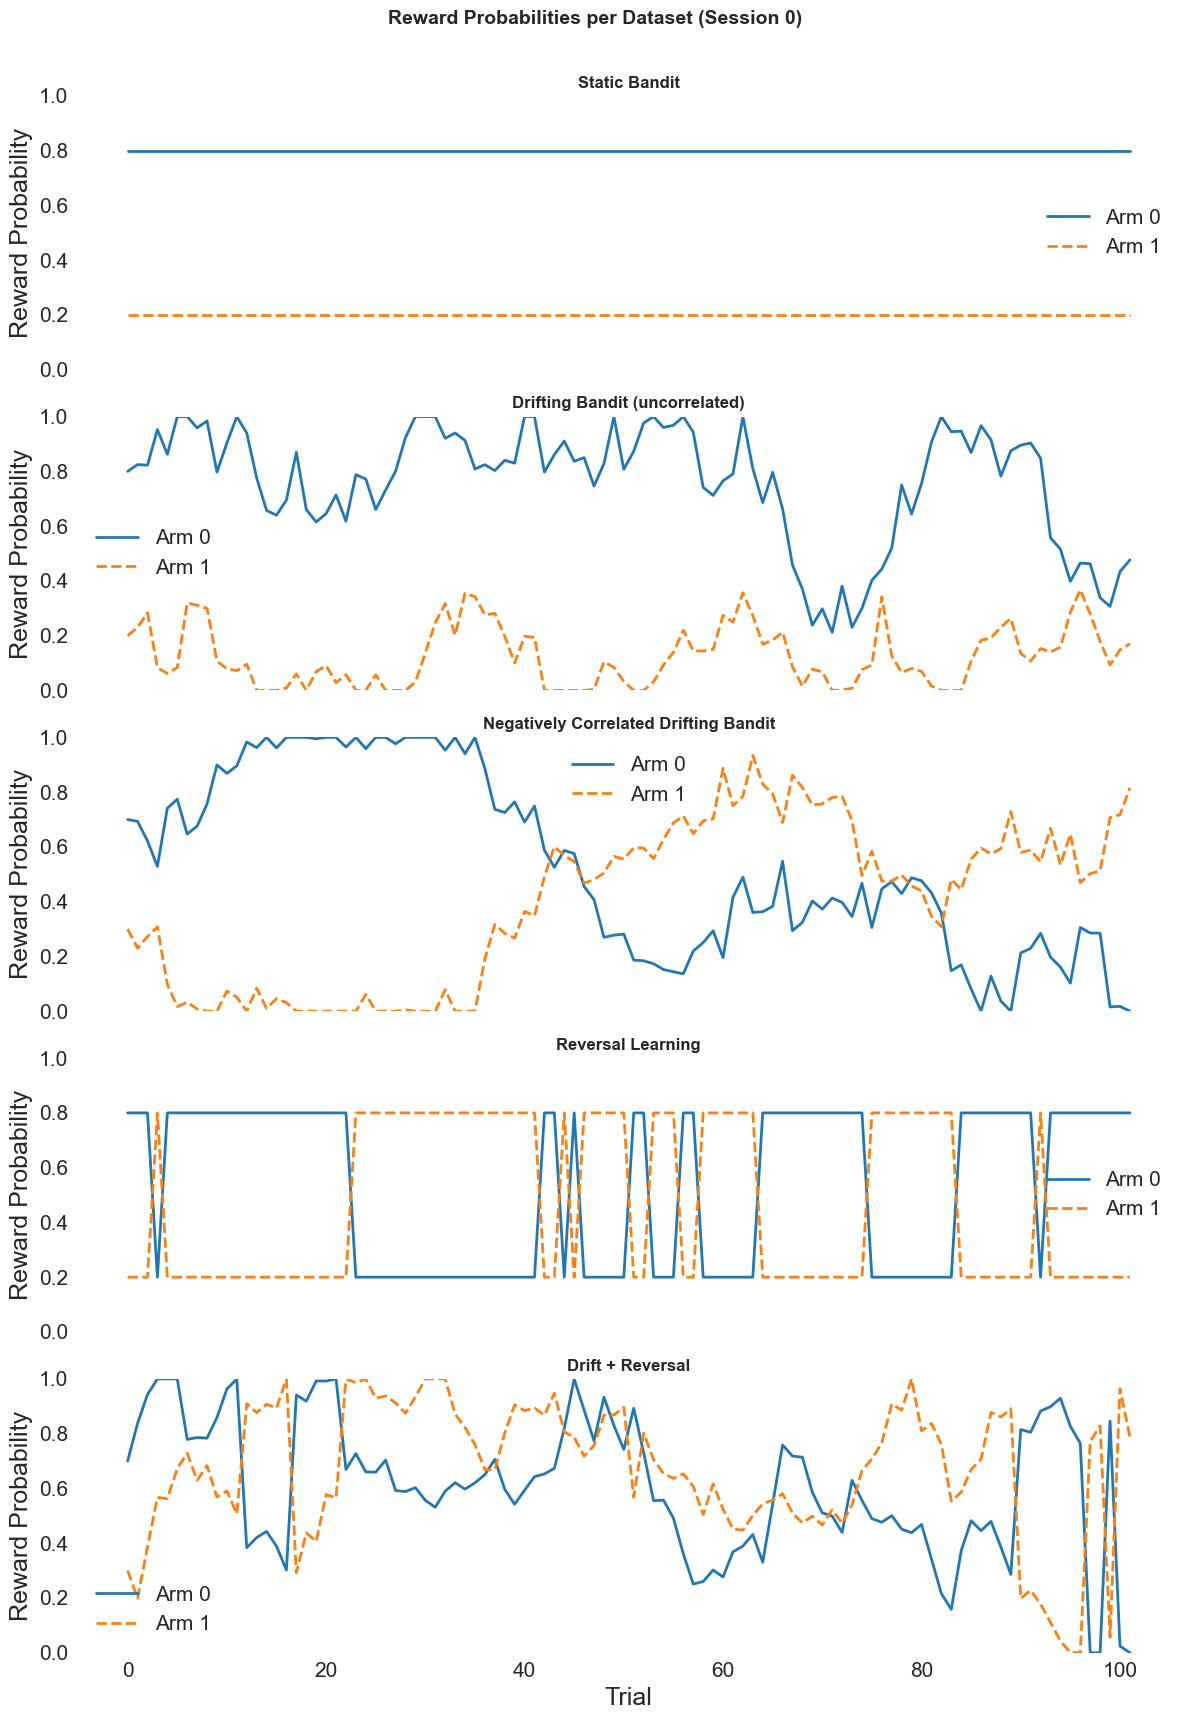

In [ ]:
from spice.utils.plotting import plot_reward_probs

# Plot reward probabilities for the first session of every dataset
DATASETS = [
    ("Static Bandit", environments['static_bandit_128p_0'].history['reward_probs']),
    ("Drifting Bandit (uncorrelated)", environments['drifting_bandit_uncorrelated_128p_0'].history['reward_probs']),
    ("Negatively Correlated Drifting Bandit", environments['negatively_correlated_drifting_bandit_128p_0'].history['reward_probs']),
    ("Reversal Learning", environments['reversal_learning_128p_0'].history['reward_probs']),
    ("Drift + Reversal", environments['drift_plus_reversal_128p_0'].history['reward_probs']),
]


fig, axes = plot_reward_probs(DATASETS)
# Save the figure
fig.savefig(f"{FIGURES_DIR}/reward_probs_all.png")


Configure agents and environments

In [8]:
from spice.utils.convert_dataset import convert_dataset

spice_dataset_static = convert_dataset(
    file=os.path.join(DATA_DIR, "static_bandit_128p_0.csv")
)

spice_dataset_drifting = convert_dataset(
    file=os.path.join(DATA_DIR, "drifting_bandit_uncorrelated_128p_0.csv")
)

spice_dataset_negatively_correlated_drifting = convert_dataset(
    file=os.path.join(DATA_DIR, "negatively_correlated_drifting_bandit_128p_0.csv")
)

spice_dataset_reversal = convert_dataset(
    file=os.path.join(DATA_DIR, "reversal_learning_128p_0.csv")
)

spice_dataset_reversal_drifting = convert_dataset(
    file=os.path.join(DATA_DIR, "drift_plus_reversal_128p_0.csv")
)

# Setup agents

In [9]:
agent_static = agents['static_bandit_128p_0']
agent_drifting = agents['drifting_bandit_uncorrelated_128p_0']
agent_negatively_correlated_drifting = agents['negatively_correlated_drifting_bandit_128p_0']
agent_reversal = agents['reversal_learning_128p_0']
agent_drift_plus_reversal = agents['drift_plus_reversal_128p_0']



In [10]:
# from analysis.experiment_embedding.create_datasets import simulate_task

# task_spec_static = dict(
#         name="Static Bandit",
#         slug="static_bandit",
#         bandit_kwargs=dict(
#             n_arms=2,
#             init_reward_prob=[0.8, 0.2],
#             drift_rate=0.0,
#             hazard_rate=0.0,
#             reward_prob_correlation=0.0,
#         ),
#         seed=101,
#     )
# df_static, sessions_static, agents_static = simulate_task(task_spec_static)

# task_spec_drifting = dict(
#         name="Drifting Bandit (uncorrelated)",
#         slug="drifting_bandit_uncorrelated",
#         bandit_kwargs=dict(
#             n_arms=2,
#             init_reward_prob=[0.8, 0.2],
#             drift_rate=0.1,
#             hazard_rate=0.0,
#             reward_prob_correlation=0.0,
#         ),
#         seed=202,
#     )
# df_drifting, sessions_drifting, agents_drifting = simulate_task(task_spec_drifting)


# Fitting SPICE to the static dataset

Now we will fit the precoded RW SPICE model to the static dataset

In [11]:
# import spice.precoded.rescorlawagner as rw
import spice.precoded.rescorlawagner as rw
from spice.estimator import SpiceEstimator

spice_estimator = SpiceEstimator(
    rnn_class=rw.SpiceModel,
    spice_config=rw.CONFIG,
    # learning_rate=1e-3,
    epochs=1024,
    verbose=True,
    sindy_weight=1.0,
    n_actions=2,
    n_participants=128,
)

spice_estimator.fit(spice_dataset_static.xs, spice_dataset_static.ys)

# spice_estimator.load_spice(path_model='static_rnn.pkl')

spice_estimator.print_spice_model()


Training the RNN...
Epoch 49/1024 --- L(Train): 0.6258906; Time: 0.04s; Convergence: 2.14e-03
(THRESHOLDING) SPICE model after 50 epochs:
Present SINDy coefficients: 2.184375047683716
value_reward_chosen[t+1] = -0.0365 value_reward_chosen[t] + 0.3409 reward 
Epoch 99/1024 --- L(Train): 0.6017242; Time: 0.04s; Convergence: 5.84e-03
(WARMUP) SPICE model after 100 epochs:
Present SINDy coefficients: 2.184375047683716
value_reward_chosen[t+1] = 0.043 value_reward_chosen[t] + 0.5496 reward 

(THRESHOLDING) SPICE model after 100 epochs:
Present SINDy coefficients: 1.599218726158142
value_reward_chosen[t+1] = 0.5496 reward 
Epoch 149/1024 --- L(Train): 0.5661004; Time: 0.04s; Convergence: 1.92e-03
(THRESHOLDING) SPICE model after 150 epochs:
Present SINDy coefficients: 1.0
value_reward_chosen[t+1] = 0.6348 reward 
Epoch 199/1024 --- L(Train): 0.5469889; Time: 0.04s; Convergence: 5.76e-04
(THRESHOLDING) SPICE model after 200 epochs:
Present SINDy coefficients: 1.0
value_reward_chosen[t+1] = 0

In [12]:
# spice_estimator.save_spice(path_rnn='static_rnn.pkl')

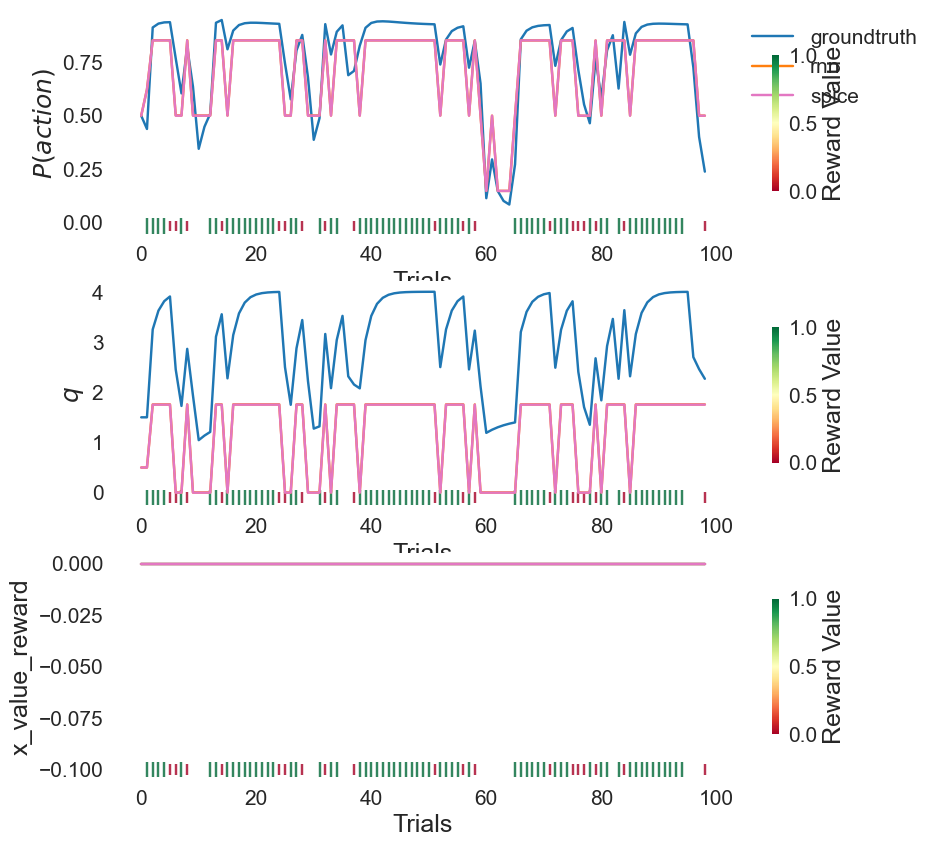

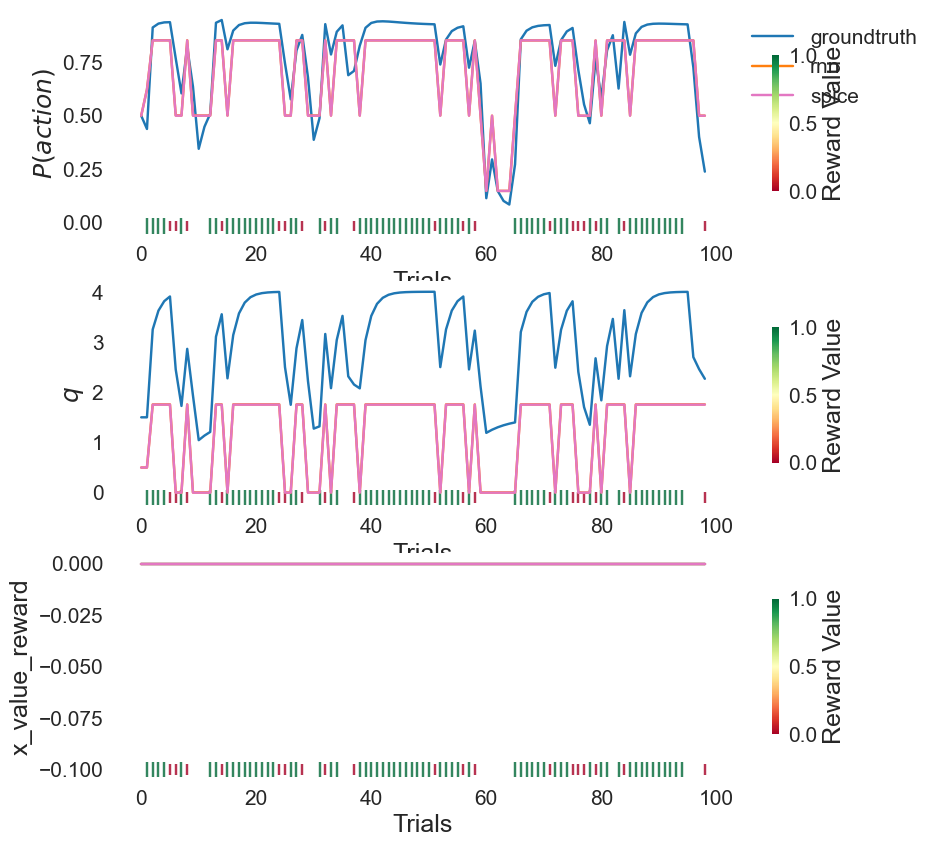

In [13]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent_static, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}

fig, axs = plot_session(agents, spice_dataset_static.xs[0], signals_to_plot=['x_value_reward'])
fig

# Drifting Bandit

In [14]:
import spice.precoded.forgetting as forgetting
from spice.estimator import SpiceEstimator

spice_estimator = SpiceEstimator(
    rnn_class=forgetting.SpiceModel,
    spice_config=forgetting.CONFIG,
    n_actions=2,
    n_participants=128,
    # learning_rate=1e-2,
    epochs=1024,

    l2_rnn=0.01,

    # sindy fitting parameters
    sindy_epochs=1024,
    sindy_threshold=0.05,
    sindy_threshold_frequency=200,
    sindy_weight=1.0,
    sindy_library_polynomial_degree=2,

    verbose=True,
    save_path_spice='drifting_rnn.pkl',
    device='cpu'
)

spice_estimator.fit(spice_dataset_drifting.xs, spice_dataset_drifting.ys)

spice_estimator.print_spice_model()


Training the RNN...
Epoch 99/1024 --- L(Train): 0.4871361; Time: 0.09s; Convergence: 2.48e-03
(WARMUP) SPICE model after 100 epochs:
Present SINDy coefficients: 9.0
value_reward_chosen[t+1] = 0.1503 1 + 0.3002 value_reward_chosen[t] + 0.4285 reward + -0.0645 value_reward_chosen^2 + -0.1033 value_reward_chosen*reward + 0.4272 reward^2 
value_reward_not_chosen[t+1] = -0.4353 1 + 0.4313 value_reward_not_chosen[t] + 0.1033 value_reward_not_chosen^2 
Epoch 199/1024 --- L(Train): 0.4544337; Time: 0.09s; Convergence: 1.80e-04
(THRESHOLDING) SPICE model after 200 epochs:
Present SINDy coefficients: 8.3203125
value_reward_chosen[t+1] = 0.0935 1 + 0.2869 value_reward_chosen[t] + 0.5268 reward + -0.0633 value_reward_chosen*reward + 0.5255 reward^2 
value_reward_not_chosen[t+1] = -0.4409 1 + 0.4746 value_reward_not_chosen[t] + 0.1163 value_reward_not_chosen^2 
Epoch 399/1024 --- L(Train): 0.4467706; Time: 0.09s; Convergence: 3.19e-04
(THRESHOLDING) SPICE model after 400 epochs:
Present SINDy coef

In [15]:
spice_estimator.print_spice_model()

value_reward_chosen[t+1] = 0.2298 value_reward_chosen[t] + 0.765 reward + 0.7641 reward^2 
value_reward_not_chosen[t+1] = -0.3719 1 + 0.3591 value_reward_not_chosen[t] + 0.1418 value_reward_not_chosen^2 


In [16]:
# spice_estimator.save_spice(path_rnn='drifting_rnn.pkl')

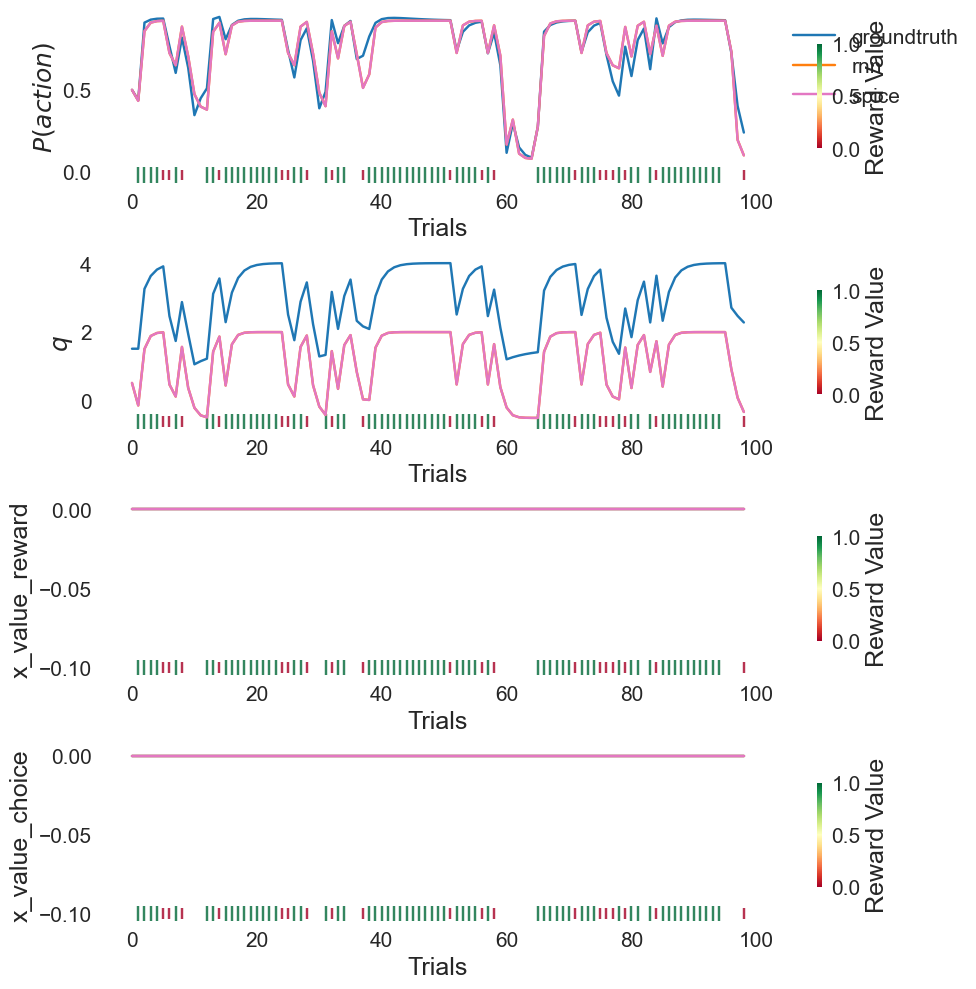

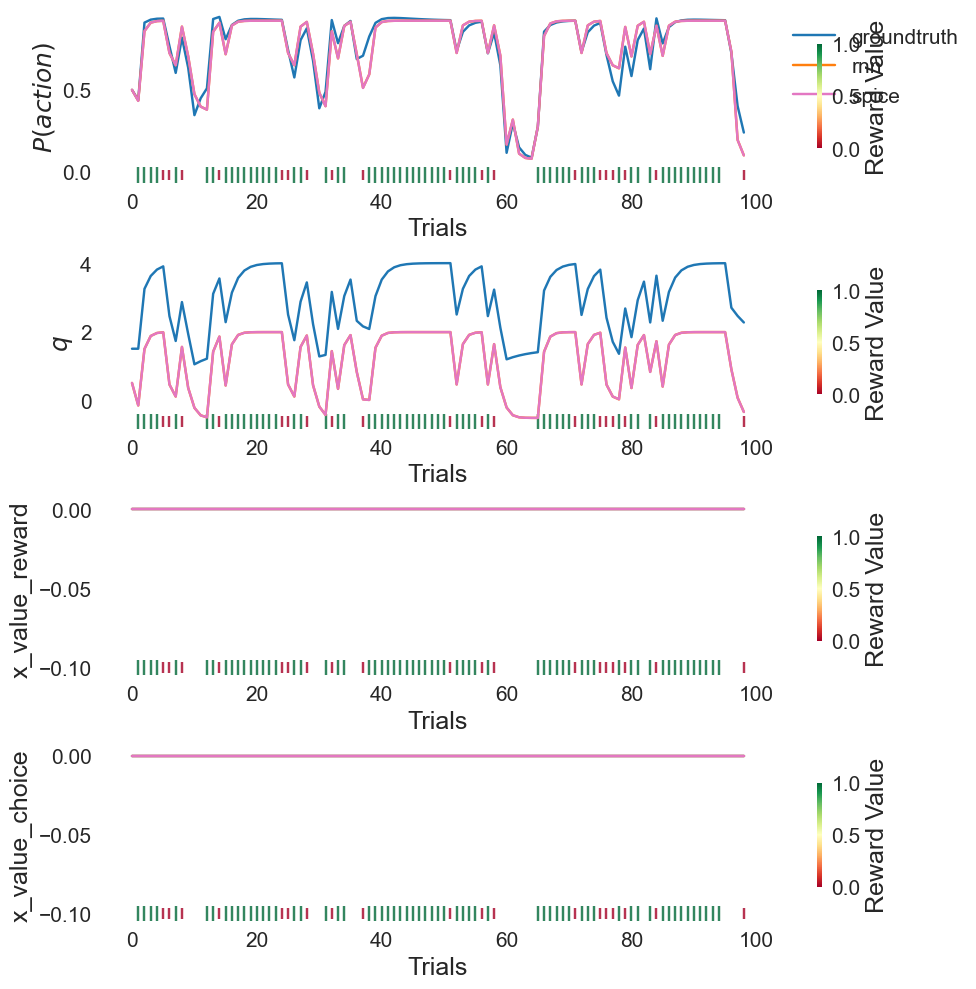

In [17]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent_drifting, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}

fig, axs = plot_session(agents, spice_dataset_static.xs[0], signals_to_plot=['x_value_reward', 'x_value_choice'])
fig.tight_layout()
fig

# Reversal learning

In [18]:
import spice.precoded.workingmemory as wm
from spice.estimator import SpiceEstimator

spice_estimator = SpiceEstimator(
    rnn_class=wm.SpiceModel,
    spice_config=wm.CONFIG,
    n_actions=2,
    n_participants=128,
    # learning_rate=1e-2,
    epochs=1024,

    l2_rnn=0.01,

    # sindy fitting parameters
    sindy_epochs=1024,
    sindy_threshold=0.05,
    sindy_threshold_frequency=200,
    sindy_weight=1.0,
    sindy_library_polynomial_degree=2,

    verbose=True,
    save_path_spice='reversal_rnn.pkl',
    device='cpu'
)

spice_estimator.fit(spice_dataset_reversal.xs, spice_dataset_reversal.ys)

spice_estimator.print_spice_model()


Training the RNN...
Epoch 99/1024 --- L(Train): 1.0459545; Time: 0.37s; Convergence: 1.18e-01
(WARMUP) SPICE model after 100 epochs:
Present SINDy coefficients: 66.0
value_reward_chosen[t+1] = -0.3736 1 + 0.1113 value_reward_chosen[t] + 0.4876 reward[t] + -0.0163 reward[t-1] + -0.0184 reward[t-2] + -0.0206 reward[t-3] + 0.0034 value_reward_chosen^2 + -0.1681 value_reward_chosen*reward[t] + -0.0661 value_reward_chosen*reward[t-1] + 0.0044 value_reward_chosen*reward[t-2] + 0.0286 value_reward_chosen*reward[t-3] + 0.4899 reward[t]^2 + 0.1916 reward[t]*reward[t-1] + 0.0523 reward[t]*reward[t-2] + 0.0388 reward[t]*reward[t-3] + -0.014 reward[t-1]^2 + 0.0152 reward[t-1]*reward[t-2] + -0.0283 reward[t-1]*reward[t-3] + -0.0164 reward[t-2]^2 + 0.0179 reward[t-2]*reward[t-3] + 0.007 reward[t-3]^2 
value_reward_not_chosen[t+1] = -0.6195 1 + 0.2718 value_reward_not_chosen[t] + 0.3128 reward[t-1] + 0.0569 reward[t-2] + 0.0264 reward[t-3] + 0.0183 value_reward_not_chosen^2 + -0.1454 value_reward_no

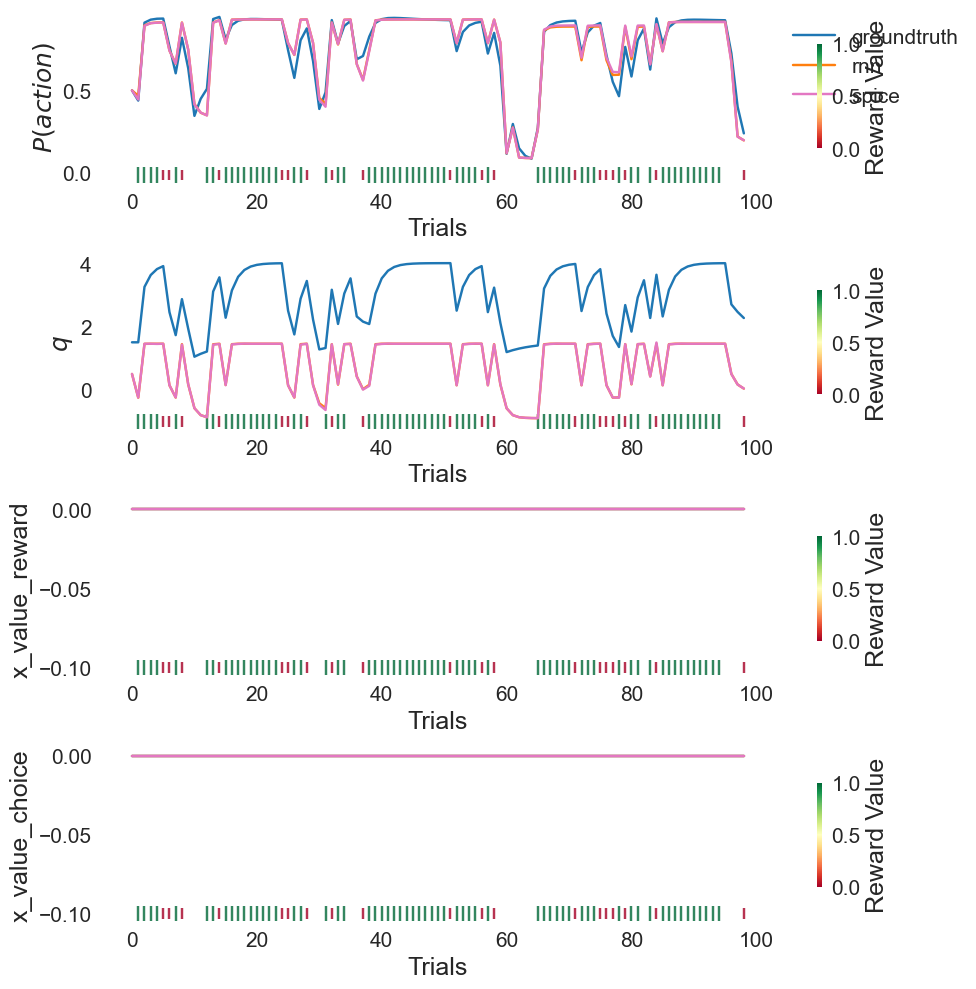

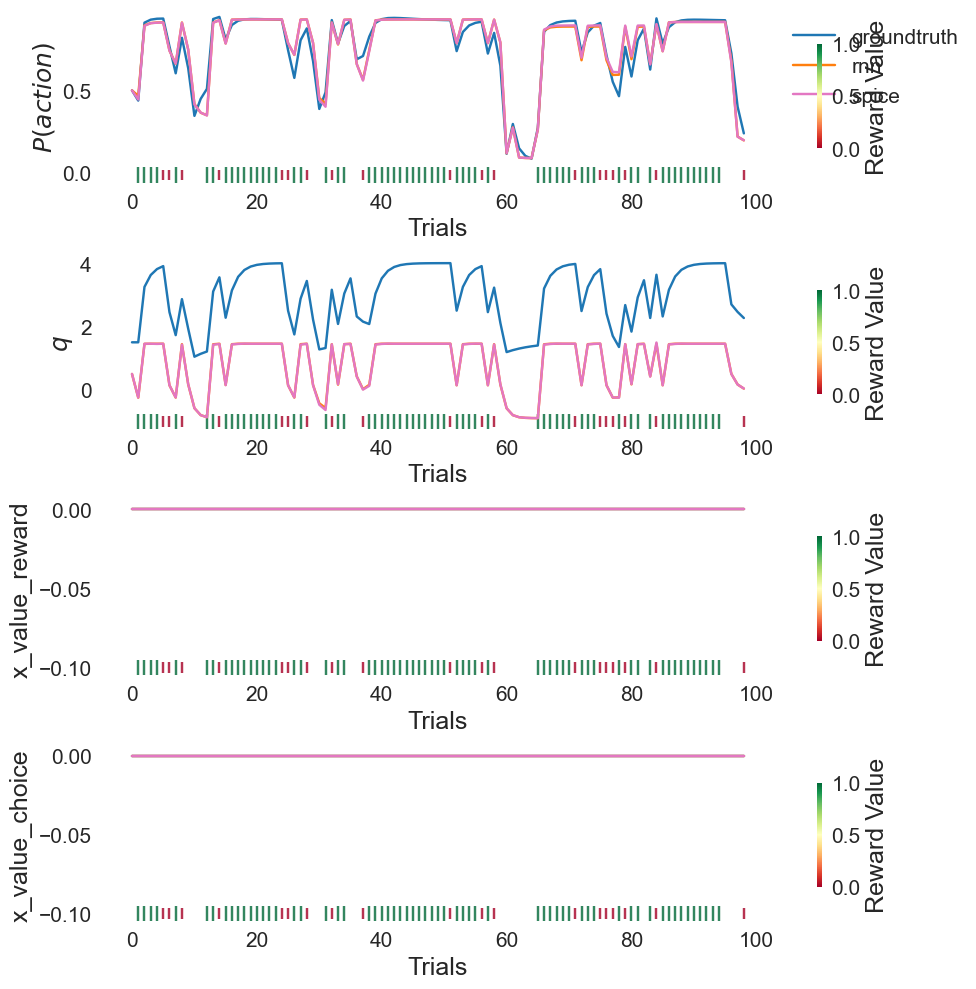

In [19]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent_drifting, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}

fig, axs = plot_session(agents, spice_dataset_static.xs[0], signals_to_plot=['x_value_reward', 'x_value_choice'])
fig.tight_layout()
fig